In [1]:
# M=[0xFFFFFFFF, 0x4BA5A933, 0x7D910E5A, 0x6D26339C, 0x71C7C3E0, 0x7E0FFC00, 0x731D8E64, 0x6B44F5B0, 0x7DC218EC, 0x4DA1B746, 0x42F0FFFF]
M = [4294967295, 1269147955, 2106658394, 1831220124, 1908917216, 2114976768, 1931316836, 1799681456, 2109872364, 1302443846, 1123090431]

# K=11 bit, S=14 symbols
C11_3gpp = zeros(Complex{Float64}, 2048, 14 * 12)
cw_QPSK = zeros(Complex{Float64}, 16)
cw = zeros(Complex{Float64}, 32);

In [2]:
function generate_d_sequence(C,M)
    D = mod(C, 2) * M[1]

    for n in 2:11
        D = xor(D, Int(mod(floor(C * 2.0^(1-n)), 2) * M[n]))
    end
    return D
end

generate_d_sequence (generic function with 1 method)

In [3]:
D = 0
for C in 0:2047
    D = generate_d_sequence(C,M)
end
println(" D =", D) # 3.2537e+09 

 D =3253698411


In [89]:
function generate_cw_sequence(D)
    cw_QPSK = zeros(ComplexF64, 16, 1)
    cw = zeros(ComplexF64, 32, 1)

    idx = 0
    for n = 0:2:31
        bit0 = 1 - 2 * Int(mod(floor(D / 2.0^n), 2))
        bit1 = 1 - 2 * Int(mod(floor(D / 2.0^(n+1)), 2))
        cw[1 + n] = bit0
        cw[2 + n] = sqrt(Complex(-1))*bit1  # to use normal BPSK, remove the pi/2 rotation
        cw_QPSK[1 + div(n, 2)] = (Float64(bit0) + im * Float64(bit1)) / sqrt(2)
    end

    return cw, cw_QPSK
end

generate_cw_sequence (generic function with 1 method)

In [90]:
cw, cw_QPSK = generate_cw_sequence(D)

println("CW Sequence: ", cw)
println("CW QPSK Sequence: ", cw_QPSK)
@show length(cw), length(cw_QPSK);

CW Sequence: ComplexF64[-1.0 + 0.0im; -0.0 - 1.0im; 1.0 + 0.0im; -0.0 - 1.0im; 1.0 + 0.0im; -0.0 - 1.0im; -1.0 + 0.0im; 0.0 + 1.0im; -1.0 + 0.0im; -0.0 - 1.0im; -1.0 + 0.0im; -0.0 - 1.0im; -1.0 + 0.0im; -0.0 - 1.0im; -1.0 + 0.0im; 0.0 + 1.0im; -1.0 + 0.0im; -0.0 - 1.0im; -1.0 + 0.0im; -0.0 - 1.0im; 1.0 + 0.0im; -0.0 - 1.0im; -1.0 + 0.0im; -0.0 - 1.0im; -1.0 + 0.0im; 0.0 + 1.0im; 1.0 + 0.0im; 0.0 + 1.0im; 1.0 + 0.0im; 0.0 + 1.0im; -1.0 + 0.0im; -0.0 - 1.0im;;]
CW QPSK Sequence: ComplexF64[-0.7071067811865475 - 0.7071067811865475im; 0.7071067811865475 - 0.7071067811865475im; 0.7071067811865475 - 0.7071067811865475im; -0.7071067811865475 + 0.7071067811865475im; -0.7071067811865475 - 0.7071067811865475im; -0.7071067811865475 - 0.7071067811865475im; -0.7071067811865475 - 0.7071067811865475im; -0.7071067811865475 + 0.7071067811865475im; -0.7071067811865475 - 0.7071067811865475im; -0.7071067811865475 - 0.7071067811865475im; 0.7071067811865475 - 0.7071067811865475im; -0.7071067811865475 - 0.70

In [91]:
function rate_matching(C, cw, cw_QPSK)
    C11_3gpp = zeros(Complex{Float64}, 2048, 14 * 12)
    C11_3gpp_QPSK = zeros(Complex{Float64}, 2048, 14 * 12)

    idx = 0
    for symb in 0:13
        for re in 0:11
            if symb == 3 || symb == 10
                C11_3gpp[1 + C, 1 + (symb * 12) .+ (0:11)] .= ones(12)  # Adjusted broadcasting
                C11_3gpp_QPSK[1 + C, 1 + (symb * 12) .+ (0:11)] .= ones(12)  # Adjusted broadcasting
                symb += 1
            end
            # println("symb $symb, re $re")
            C11_3gpp[1 + C, 1 + (symb * 12) + re] = cw[1 + rem(idx, 32)]  # rate-matching of the cw-sequence
            x1 = 1 + C
            x2 = 1 + (symb * 12) + re;
            x3 = cw[1 + rem(idx, 32)]
            # println("1 + C $x1, x2 $x2, x3 $x3")
            C11_3gpp_QPSK[1 + C, 1 + (symb * 12) + re] = cw_QPSK[1 + rem(idx, 16)]  # rate-matching of the cw-sequence
            idx += 1
        end
    end
    return C11_3gpp, C11_3gpp_QPSK
end

rate_matching (generic function with 1 method)

In [93]:
# C is the code sequence to be generated
C=77;
c0_t = zeros(Complex{Float64}, 2048, 14 * 12)
c0_t_QPSK = zeros(Complex{Float64}, 2048, 14 * 12)

C11_3gpp, C11_3gpp_QPSK = rate_matching(C, cw, cw_QPSK)
@show C11_3gpp[78,1:5], C11_3gpp_QPSK[78,1:5]

(C11_3gpp[78, 1:5], C11_3gpp_QPSK[78, 1:5]) = (ComplexF64[-1.0 + 0.0im, -0.0 - 1.0im, 1.0 + 0.0im, -0.0 - 1.0im, 1.0 + 0.0im], ComplexF64[-0.7071067811865475 - 0.7071067811865475im, 0.7071067811865475 - 0.7071067811865475im, 0.7071067811865475 - 0.7071067811865475im, -0.7071067811865475 + 0.7071067811865475im, -0.7071067811865475 - 0.7071067811865475im])


(ComplexF64[-1.0 + 0.0im, -0.0 - 1.0im, 1.0 + 0.0im, -0.0 - 1.0im, 1.0 + 0.0im], ComplexF64[-0.7071067811865475 - 0.7071067811865475im, 0.7071067811865475 - 0.7071067811865475im, 0.7071067811865475 - 0.7071067811865475im, -0.7071067811865475 + 0.7071067811865475im, -0.7071067811865475 - 0.7071067811865475im])

In [94]:
using FFTW

In [73]:
function generate_c0_t(C, C11_3gpp, C11_3gpp_QPSK)
    c0_t = []
    c0_t_QPSK = []

    for symb in 0:13
        # extract OFDM symbols "symb" from the coded sequence and perform DFT-precoding (SC-FDMA)
        if symb == 3
            symb = 4
        end
        if symb == 10
            symb = 11
        end

        c0_f = fft(C11_3gpp[1 + C, 1 + symb * 12 : 1 + symb * 12 + 11])
        c0_f_QPSK = fft(C11_3gpp_QPSK[1 + C, 1 + symb * 12 : 1 + symb * 12 + 11])
        @show size(c0_f), size(c0_f_QPSK)

        # Use the entire array with ifft and then extract real and imaginary parts
        push!(c0_t, real(ifft(c0_f)))
        push!(c0_t_QPSK, real(ifft(c0_f_QPSK)))
        # push!(c0_t, ifft(c0_f, 14))
        # push!(c0_t_QPSK, ifft(c0_t_QPSK, 14))
        # @show c0_t
    end

    # Reshape arrays if needed
    c0_t = hcat(c0_t...)
    c0_t_QPSK = hcat(c0_t_QPSK...)

    return c0_t, c0_t_QPSK
end


generate_c0_t (generic function with 1 method)

In [74]:
c0_t, c0_t_QPSK = generate_c0_t(C, C11_3gpp, C11_3gpp_QPSK);
@show length(c0_t), length(c0_t_QPSK)

(size(c0_f), size(c0_f_QPSK)) = ((12,), (12,))
(size(c0_f), size(c0_f_QPSK)) = ((12,), (12,))
(size(c0_f), size(c0_f_QPSK)) = ((12,), (12,))
(size(c0_f), size(c0_f_QPSK)) = ((12,), (12,))
(size(c0_f), size(c0_f_QPSK)) = ((12,), (12,))
(size(c0_f), size(c0_f_QPSK)) = ((12,), (12,))
(size(c0_f), size(c0_f_QPSK)) = ((12,), (12,))
(size(c0_f), size(c0_f_QPSK)) = ((12,), (12,))
(size(c0_f), size(c0_f_QPSK)) = ((12,), (12,))
(size(c0_f), size(c0_f_QPSK)) = ((12,), (12,))
(size(c0_f), size(c0_f_QPSK)) = ((12,), (12,))
(size(c0_f), size(c0_f_QPSK)) = ((12,), (12,))
(size(c0_f), size(c0_f_QPSK)) = ((12,), (12,))
(size(c0_f), size(c0_f_QPSK)) = ((12,), (12,))
(length(c0_t), length(c0_t_QPSK)) = (168, 168)


(168, 168)

In [75]:
using Plots

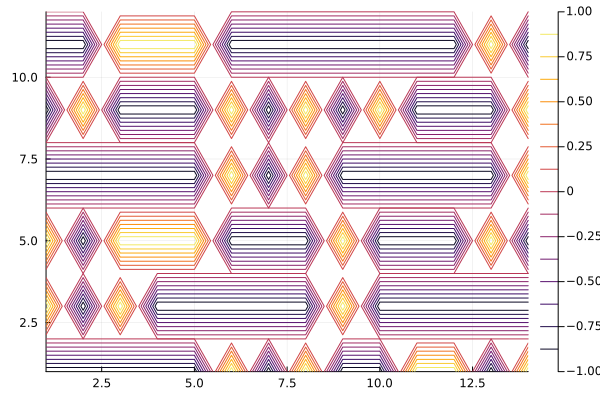

attempt to save state beyond implementation limit
attempt to save state beyond implementation limit


In [88]:
contour(c0_t)

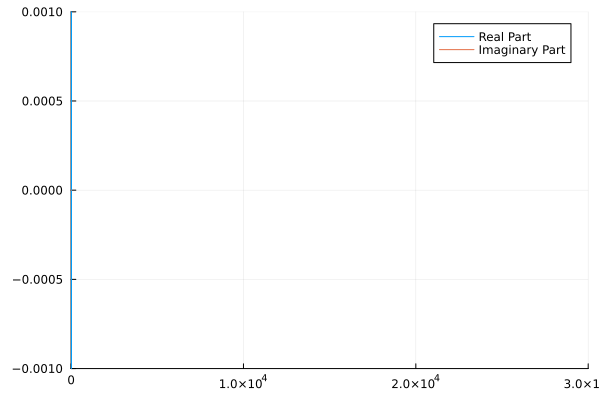

In [77]:
# Figure 1
plot(real(c0_t[1,:]), label="Real Part", xlims= (0, 30000), ylims = (-0.001, 0.001))
plot!(imag(c0_t[1,:]), label="Imaginary Part", xlims= (0, 30000), ylims = (-0.001, 0.001))

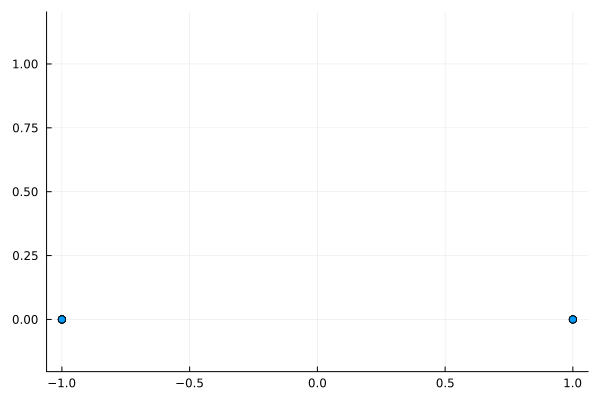

In [78]:
# Figure 2
plot(real(c0_t[1, :]), imag(c0_t[1, :]), seriestype=:scatter, label="", aspect_ratio=:equal)

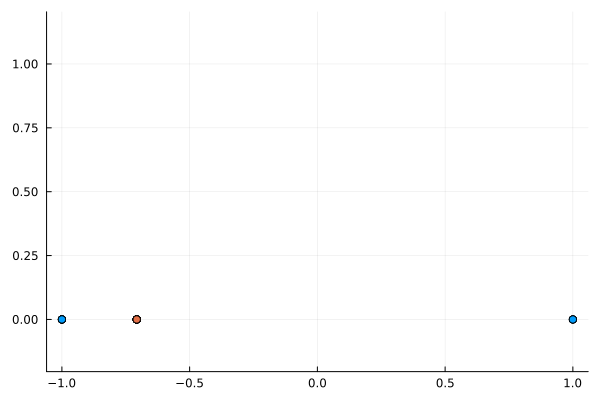

In [79]:
# Figure 3
plot!(real(c0_t_QPSK[1, :]), imag(c0_t_QPSK[1, :]), seriestype=:scatter, label="", aspect_ratio=:equal)